In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler

## Dataset

In [51]:
df = pd.read_csv('datasets/btc_3m.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df

,open,high,low,close,volume
datetime,,,,,
2018-01-01 05:30:00,13715.65,13715.65,13666.11,13680.00,6.303815
2018-01-01 05:33:00,13679.98,13679.98,13554.44,13568.00,33.709206
2018-01-01 05:36:00,13568.00,13575.00,13501.01,13575.00,29.645987
2018-01-01 05:39:00,13539.99,13575.00,13400.01,13515.26,30.696039
2018-01-01 05:42:00,13515.26,13568.66,13473.47,13556.15,23.260966
...,...,...,...,...,...
2022-01-31 05:18:00,37919.05,37919.05,37876.94,37891.30,30.717900
2022-01-31 05:21:00,37891.30,37946.56,37870.00,37918.80,28.369420
2022-01-31 05:24:00,37918.79,37948.79,37888.88,37898.01,22.346010


In [52]:
# Filtering the dataset

start_date = '2018-01-01'
end_date = '2019-01-01'
filtered_df = df.loc[start_date:end_date]
print(filtered_df.shape)
filtered_df.iloc[[0,-1],:]

(174247, 5)


,open,high,low,close,volume
datetime,,,,,
2018-01-01 05:30:00,13715.65,13715.65,13666.11,13680.00,6.303815
2019-01-01 23:57:00,3678.00,3680.33,3675.25,3675.26,19.906142


In [53]:
# Adding indicators

def calculate_rsi(data, period=14):
    close_diff = data['close'].diff(1)
    gain = close_diff.where(close_diff > 0, 0)
    loss = -close_diff.where(close_diff < 0, 0)

    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

filtered_df['RSI'] = calculate_rsi(filtered_df)

# Calculate Moving Average Convergence Divergence (MACD) and Signal Line
def calculate_macd(data, fast_period=12, slow_period=26, signal_period=9):
    exp12 = data['close'].ewm(span=fast_period, adjust=False).mean()
    exp26 = data['close'].ewm(span=slow_period, adjust=False).mean()

    macd = exp12 - exp26
    signal = macd.ewm(span=signal_period, adjust=False).mean()

    return macd, signal

filtered_df['MACD'], filtered_df['signal_line'] = calculate_macd(filtered_df)
filtered_df['MACD_signal_diff'] = filtered_df['MACD'] - filtered_df['signal_line']
filtered_df.drop(columns=['MACD','signal_line'],inplace=True)

# Calculate Exponential Moving Average (EMA)
filtered_df['EMA'] = filtered_df['close'].ewm(span=14, adjust=False).mean()

# Calculate Moving Averages (50 and 100)
filtered_df['MA_50'] = filtered_df['close'].rolling(window=50).mean()
filtered_df['MA_100'] = filtered_df['close'].rolling(window=100).mean()

# Calculate On Balance Volume (OBV)
filtered_df['OBV'] = filtered_df['volume'].cumsum()

# Dropping rows with null values
filtered_df.dropna(inplace=True)

# Print the updated DataFrame
print(filtered_df.shape)
filtered_df.head()

(174148, 11)


C:\Users\sanya\AppData\Local\Temp\ipykernel_13692\2212376076.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['RSI'] = calculate_rsi(filtered_df)
C:\Users\sanya\AppData\Local\Temp\ipykernel_13692\2212376076.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['MACD'], filtered_df['signal_line'] = calculate_macd(filtered_df)
C:\Users\sanya\AppData\Local\Temp\ipykernel_13692\2212376076.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

,open,high,low,close,volume,RSI,MACD_signal_diff,EMA,MA_50,MA_100,OBV
datetime,,,,,,,,,,,
2018-01-01 10:27:00,13565.01,13623.29,13532.42,13601.01,46.215130,83.643678,16.877722,13506.154842,13429.2028,13443.1829,2017.012136
2018-01-01 10:30:00,13615.20,13677.83,13572.10,13636.37,48.997021,84.759188,19.047744,13523.516863,13436.5518,13442.7466,2066.009157
2018-01-01 10:33:00,13648.24,13671.43,13610.02,13640.00,31.461851,82.956792,19.406885,13539.047948,13443.4608,13443.4666,2097.471008
2018-01-01 10:36:00,13640.01,13667.65,13600.00,13640.53,45.699336,80.691694,18.370107,13552.578888,13451.7568,13444.1219,2143.170344
2018-01-01 10:39:00,13640.53,13663.99,13552.02,13552.03,33.411619,64.585375,10.789188,13552.505703,13458.2754,13444.4896,2176.581963


In [54]:
# Adding the change in close price column

filtered_df['close_change'] = filtered_df['close'].shift(-1) - filtered_df['close']
filtered_df.head()

C:\Users\sanya\AppData\Local\Temp\ipykernel_13692\1043046407.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close_change'] = filtered_df['close'].shift(-1) - filtered_df['close']


,open,high,low,close,volume,RSI,MACD_signal_diff,EMA,MA_50,MA_100,OBV,close_change
datetime,,,,,,,,,,,,
2018-01-01 10:27:00,13565.01,13623.29,13532.42,13601.01,46.215130,83.643678,16.877722,13506.154842,13429.2028,13443.1829,2017.012136,35.36
2018-01-01 10:30:00,13615.20,13677.83,13572.10,13636.37,48.997021,84.759188,19.047744,13523.516863,13436.5518,13442.7466,2066.009157,3.63
2018-01-01 10:33:00,13648.24,13671.43,13610.02,13640.00,31.461851,82.956792,19.406885,13539.047948,13443.4608,13443.4666,2097.471008,0.53
2018-01-01 10:36:00,13640.01,13667.65,13600.00,13640.53,45.699336,80.691694,18.370107,13552.578888,13451.7568,13444.1219,2143.170344,-88.50
2018-01-01 10:39:00,13640.53,13663.99,13552.02,13552.03,33.411619,64.585375,10.789188,13552.505703,13458.2754,13444.4896,2176.581963,75.11


### Train test split and preparing data for LSTM

In [55]:
# We will only try to predict the close price
filtered_df = filtered_df['close']
filtered_df.head()

datetime
2018-01-01 10:27:00    13601.01
2018-01-01 10:30:00    13636.37
2018-01-01 10:33:00    13640.00
2018-01-01 10:36:00    13640.53
2018-01-01 10:39:00    13552.03
Name: close, dtype: float64

In [56]:
# Train test split
split_ratio = 0.8
split_index = int(split_ratio * len(filtered_df))

train_data, test_data = np.array(filtered_df[:split_index]), np.array(filtered_df[split_index:]) 

print(f"train shape:{train_data.shape}")
print(f"test shape:{test_data.shape}")

train shape:(139318,)
test shape:(34830,)


In [57]:
# Scaling the data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data.reshape(-1,1))
test_data = scaler.transform(test_data.reshape(-1,1))

In [58]:
# Making sequences
def create_sequences(data, sequence_length=14):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length: i])
        y.append(data[i])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (139304, 14, 1)
y_train shape: (139304, 1)
X_test shape: (34816, 14, 1)
y_test shape: (34816, 1)


## LSTM Model

In [10]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.activations import leaky_relu
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint

In [11]:
time_stamp = datetime.datetime.timestamp(datetime.datetime.now())

In [12]:
cp_path = f"models/BTC_LSTM_cp_{time_stamp}.h5"
cp_callback = ModelCheckpoint(cp_path
                              ,monitor="val_loss"
                              ,save_best_only=True
                              ,mode='min')

In [68]:
X_train.shape

(139304, 14, 1)

In [14]:
model = Sequential()
model.add(LSTM(64,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64))
model.add(Dense(1))

model.compile(loss='mean_absolute_error',
              optimizer=Adam(),
              metrics=['mean_squared_error'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 64)            16896     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=32, callbacks=[cp_callback])

Epoch 1/32
3483/3483 [==============================] - 81s 21ms/step - loss: 0.0041 - mean_squared_error: 9.8432e-05 - val_loss: 7.9218e-04 - val_mean_squared_error: 1.4940e-06
Epoch 2/32
3483/3483 [==============================] - 51s 15ms/step - loss: 0.0025 - mean_squared_error: 1.4468e-05 - val_loss: 4.9613e-04 - val_mean_squared_error: 7.4579e-07
Epoch 3/32
3483/3483 [==============================] - 26s 7ms/step - loss: 0.0021 - mean_squared_error: 1.0684e-05 - val_loss: 5.7786e-04 - val_mean_squared_error: 7.5909e-07
Epoch 4/32
3483/3483 [==============================] - 26s 7ms/step - loss: 0.0020 - mean_squared_error: 9.5179e-06 - val_loss: 4.4284e-04 - val_mean_squared_error: 5.7123e-07
Epoch 5/32
3483/3483 [==============================] - 28s 8ms/step - loss: 0.0019 - mean_squared_error: 9.3029e-06 - val_loss: 4.3144e-04 - val_mean_squared_error: 5.5542e-07
Epoch 6/32
3483/3483 [==============================] - 33s 9ms/step - loss: 0.0019 - mean_squared_error: 8.6508e

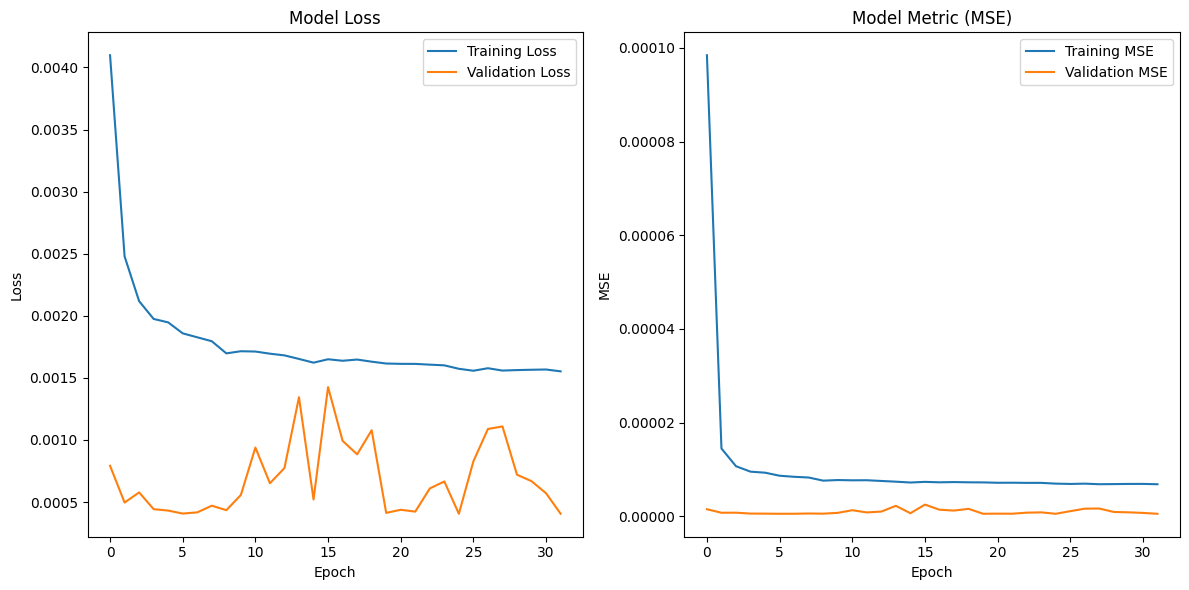

In [16]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation metrics (e.g., Mean Squared Error)
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Model Metric (MSE)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
model.save(f"models/BTC_LSTM_{time_stamp}.h5")

In [42]:
time_stamp

1704897479.313657

In [18]:
from keras.models import load_model
model = load_model(f'models/BTC_LSTM_cp_{time_stamp}.h5')

In [19]:
# Evaluateing the test loss

model.evaluate(X_test,y_test)

1088/1088 [==============================] - 4s 3ms/step - loss: 9.2702e-04 - mean_squared_error: 1.6607e-06


[0.000927018525544554, 1.660743464526604e-06]

In [20]:
predictions = model.predict(X_test)

# Inverse transformation
predicted_values = scaler.inverse_transform(predictions)
original_values = scaler.inverse_transform(y_test.reshape(-1, 1))

1088/1088 [==============================] - 3s 3ms/step


In [27]:
for i in range(len(predicted_values)):
    print(f"Actual:{original_values[i]}\tPredicted:{predicted_values[i]}")

Actual:[6588.33]	Predicted:[6590.771]
Actual:[6596.12]	Predicted:[6588.814]
Actual:[6592.43]	Predicted:[6595.506]
Actual:[6592.14]	Predicted:[6591.8027]
Actual:[6590.53]	Predicted:[6591.842]
Actual:[6590.01]	Predicted:[6590.7036]
Actual:[6592.37]	Predicted:[6590.0205]
Actual:[6583.31]	Predicted:[6591.693]
Actual:[6580.46]	Predicted:[6583.472]
Actual:[6574.]	Predicted:[6581.0127]
Actual:[6574.17]	Predicted:[6575.0605]
Actual:[6574.41]	Predicted:[6574.689]
Actual:[6574.66]	Predicted:[6574.7646]
Actual:[6583.1]	Predicted:[6574.5347]
Actual:[6583.31]	Predicted:[6582.052]
Actual:[6581.26]	Predicted:[6582.06]
Actual:[6582.37]	Predicted:[6580.515]
Actual:[6584.74]	Predicted:[6581.7783]
Actual:[6586.83]	Predicted:[6583.766]
Actual:[6586.27]	Predicted:[6585.7544]
Actual:[6585.99]	Predicted:[6585.8774]
Actual:[6582.7]	Predicted:[6585.403]
Actual:[6586.93]	Predicted:[6582.291]
Actual:[6588.98]	Predicted:[6586.819]
Actual:[6588.17]	Predicted:[6588.0967]
Actual:[6588.4]	Predicted:[6587.509]
Actual:

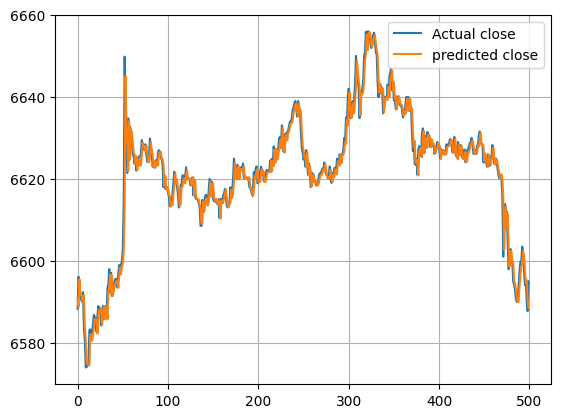

In [67]:
plt.plot(original_values[:500], label="Actual close")
plt.plot(predicted_values[:500], label="predicted close")
plt.legend()
plt.grid()

In [59]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('models/BTC_LSTM_cp_1704897479.313657.h5')

In [60]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

1088/1088 [==============================] - 5s 4ms/step


In [41]:
from sklearn.metrics import mean_absolute_percentage_error

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the accuracy
accuracy = mean_absolute_percentage_error(y_test, y_pred)

print(f'The accuracy of the model is {accuracy:.2f}')

1088/1088 [==============================] - 4s 3ms/step
The accuracy of the model is 0.02


## Trade simulation

In [ ]:
features = ["open"	,"high",	"low" ,"volume" , "rsi"]

In [ ]:
balance_usdt = 10000
balance_btc = 0
stop_loss = balance_btc*(0.002)

for i in range(df_3m.shape[0]):
    
    # get the date for the i th row
    date = df_3m.iloc[i]['datetime']

    # Get the data for the date
    data = df_3m[df_3m['datetime'] == date]

    # Get the feature vector for the date
    x = data.drop(columns=['datetime','close_Change'])
    print(x.as_numpy())
    # Predict the price using the model
    y_pred = model.predict(x)

    # difference between the predicted close and actual open
    open=data["open"].values[0]
    close_predicted=y_pred[0]
    diff = close_predicted-open

    # Compare the predicted class with the actual class
    if diff > 0 and balance_usdt>0:
        btc=(balance_usdt-0.0015*balance_usdt)/open
        stop_loss = balance_usdt*(0.002)
        balance_btc=btc
        balance_usdt=0
        print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [buying]')

    elif diff<0 and diff < (-stop_loss) and balance_btc>0:  # Changed this line
        usdt=balance_btc*open
        balance_usdt=usdt-(0.0015*usdt)
        balance_btc=0
        print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [selling]')
    else:
        print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [holding]')

    #if loop reached the end convert all btc to usd
    if i==df.shape[0]-1 and balance_usdt==0:
        usdt=balance_btc*open
        balance_usdt=usdt
        balance_btc=0
    #print the balance and btc
    
# Print the final balances after executing the trades
print(f"Final Balances: USDT {balance_usdt}, BTC {balance_btc}")